https://www.youtube.com/watch?v=NKHQiN-08S8&t=13s

In [2]:
!pip install arch

     |████████████████████████████████| 808kB 3.9MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns #visualisation
#import seaborn as sns    
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas_datareader as pdr
from datetime import datetime, timedelta

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tesla Volatility

In [4]:
start_date = '2010-06-30'
end_date = '2020-11-30'

# User pandas_reader.data.DataReader to load the desired data.
tesladf = pdr.data.DataReader( "TSLA", 'yahoo', start_date, end_date)

In [5]:
from google.colab import files
tesladf.to_csv('tesla.csv') 
#files.download('tesla.csv')

In [6]:
tesladf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2624 entries, 2010-06-30 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2624 non-null   float64
 1   Low        2624 non-null   float64
 2   Open       2624 non-null   float64
 3   Close      2624 non-null   float64
 4   Volume     2624 non-null   float64
 5   Adj Close  2624 non-null   float64
dtypes: float64(6)
memory usage: 143.5 KB


In [7]:
returns = 100 * tesladf.Close.pct_change().dropna()

Text(0.5, 1.0, 'Tesla Returns')

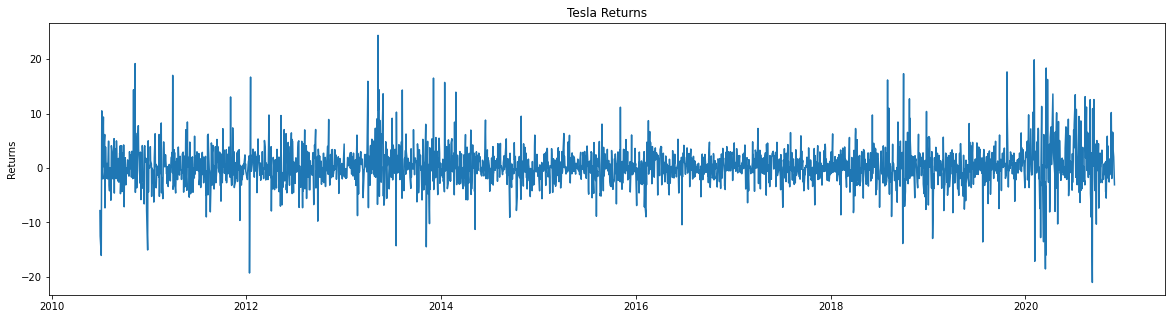

In [8]:
plt.figure(figsize = (20,5))
plt.plot(returns)
plt.ylabel('Returns')
plt.title('Tesla Returns')
#percent change of tesla stock between one day in the next from 2010(June) to 2020(November)

From the result shows a lot of volatitilies in previous years

PACF - to know which Garch process should be used

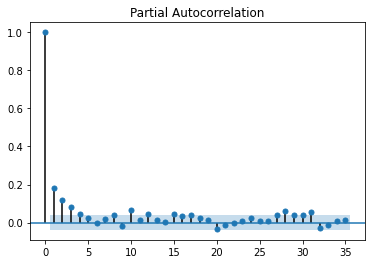

In [9]:
plot_pacf(returns**2)
plt.show()

In [10]:
teslamodel = arch_model(returns, p = 4, q = 4)

In [ ]:
teslamodel_fit = teslamodel.fit()

In [12]:
teslamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6865.96
Distribution:                  Normal   AIC:                           13751.9
Method:            Maximum Likelihood   BIC:                           13810.6
                                        No. Observations:                 2623
Date:                Fri, May 14 2021   Df Residuals:                     2622
Time:                        16:21:16   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1733  8.153e-02      2.125  3.357e-02 [1.347e-02,  0.333]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1370      0.203      0.674      0.501     [ -0.262,  0.536]
alpha[1]       0.0400  1.611e-02      2.484  1.301e-02 [8.436e-03,7.158e-02]
alpha[2]   3.7460e-03      0.180  2.079e-02      0.983     [ -0.349,  0.357]
alpha[3]       0.0000      0.358      0.000      1.000     [ -0.701,  0.701]
alpha[4]       0.0000      0.245      0.000      1.000     [ -0.480,  0.480]
beta[1]        0.6685      2.242      0.298      0.766     [ -3.725,  5.062]
beta[2]        0.0000      6.877      0.000      1.000     [-13.479, 13.479]
beta[3]        0.0000      8.936      0.000      1.000     [-17.514, 17.514]
beta[4]        0.2762      4.217  6.549e-02      0.948     [ -7.990,  8.542]
============================================================================

Covariance estimator: robust
"""

In [13]:
teslamodel = arch_model(returns, p = 1, q = 0)

In [ ]:
teslamodel_fit = teslamodel.fit()

In [15]:
teslamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6980.68
Distribution:                  Normal   AIC:                           13967.4
Method:            Maximum Likelihood   BIC:                           13985.0
                                        No. Observations:                 2623
Date:                Fri, May 14 2021   Df Residuals:                     2622
Time:                        16:21:26   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2614  6.756e-02      3.870  1.091e-04 [  0.129,  0.394]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         10.5711      0.737     14.337  1.278e-46   [  9.126, 12.016]
alpha[1]       0.1536  3.641e-02      4.219  2.457e-05 [8.225e-02,  0.225]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
rolling_predictions = []
test_size = 365 #365 days

for i in range(test_size):
  train = returns[:-(test_size-i)]
  teslamodel = arch_model(train, p = 1, q = 0)
  teslamodel_fit = teslamodel.fit(disp = 'off')
  pred = teslamodel_fit.forecast(horizon=1)
  rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [17]:
rolling_predictions = pd.Series(rolling_predictions, index = returns.index[-365:])

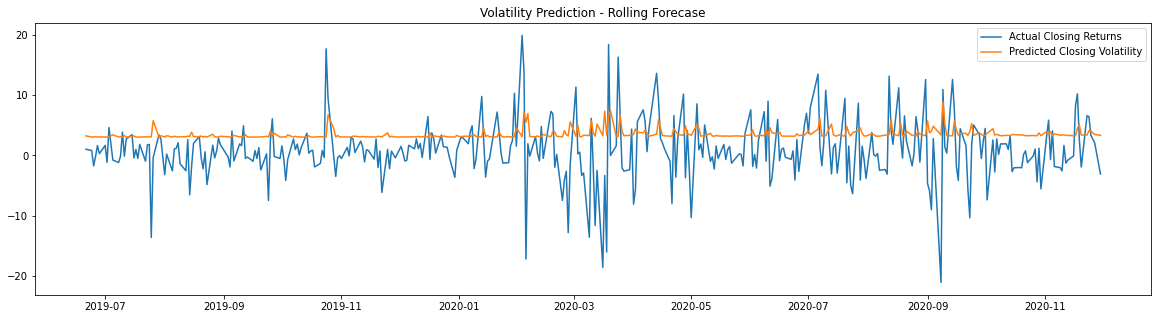

In [18]:
plt.figure(figsize=(20,5))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecase')
plt.legend(['Actual Closing Returns','Predicted Closing Volatility'])

In [19]:
train = returns
teslamodel = arch_model(train, p = 1, q = 0)
teslamodel_fit = teslamodel.fit(disp = 'off')

In [ ]:
pred = teslamodel_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

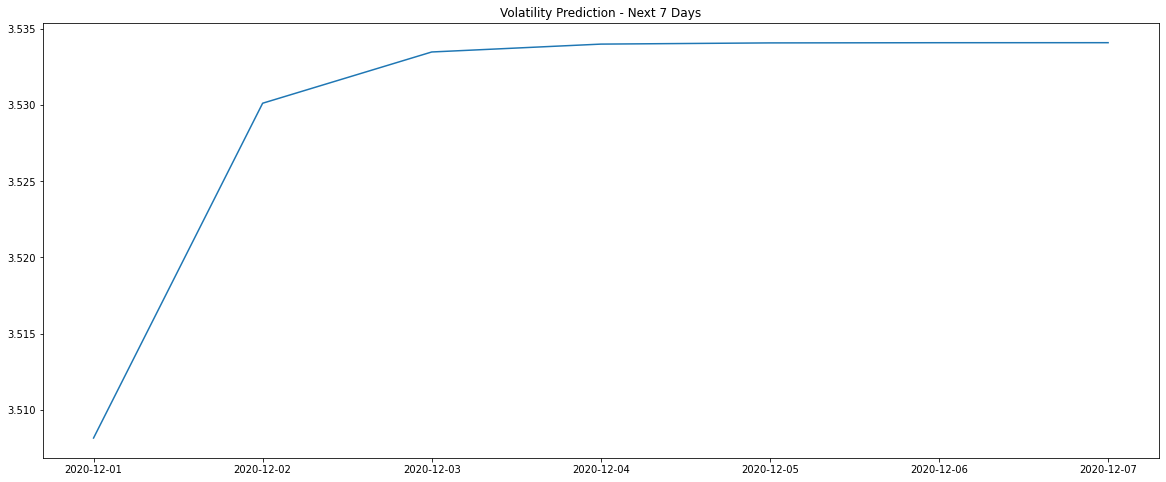

In [21]:
plt.figure(figsize=(20,8))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days')

**BMW Stock**

In [70]:
start_date = '1996-11-09'
end_date = '2020-11-30'

bmwdf = pdr.data.DataReader( "BMW.DE", 'yahoo', start_date, end_date)

In [71]:
from google.colab import files
bmwdf.to_csv('bmw.csv') 
#files.download('bmw.csv')

In [72]:
bmw_returns = 100 * bmwdf.Close.pct_change().dropna()

Text(0.5, 1.0, 'BMW Returns')

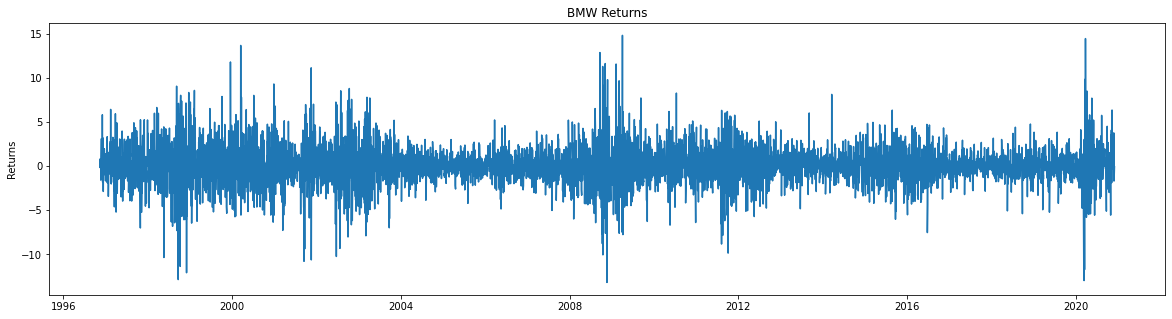

In [73]:
plt.figure(figsize = (20,5))
plt.plot(bmw_returns)
plt.ylabel('Returns')
plt.title('BMW Returns')
#percent change of bmw stock between one day in the next from 1996 November to 2020(November)

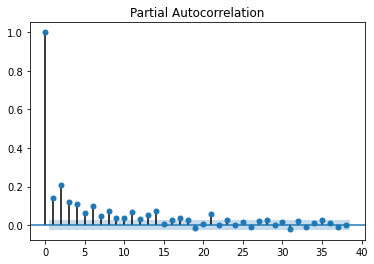

In [74]:
plot_pacf(bmw_returns**2)
plt.show()

In [75]:
bmwmodel = arch_model(bmw_returns, p = 8, q = 8)

In [ ]:
bmwmodel_fit = bmwmodel.fit()

In [77]:
bmwmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12696.0
Distribution:                  Normal   AIC:                           25428.0
Method:            Maximum Likelihood   BIC:                           25549.1
                                        No. Observations:                 6169
Date:                Fri, May 14 2021   Df Residuals:                     6168
Time:                        16:31:29   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0579  2.125e-02      2.725  6.429e-03 [1.626e-02,9.954e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1391  8.285e-02      1.679  9.321e-02   [-2.330e-02,  0.301]
alpha[1]       0.0471  1.900e-02      2.480  1.314e-02  [9.878e-03,8.436e-02]
alpha[2]       0.0608  3.130e-02      1.943  5.205e-02   [-5.388e-04,  0.122]
alpha[3]       0.0423  4.667e-02      0.906      0.365   [-4.921e-02,  0.134]
alpha[4]       0.0546  3.341e-02      1.634      0.102   [-1.090e-02,  0.120]
alpha[5]       0.0242  2.867e-02      0.844      0.399 [-3.200e-02,8.038e-02]
alpha[6]       0.0368  4.365e-02      0.844      0.399   [-4.873e-02,  0.122]
alpha[7]   5.2265e-03  4.059e-02      0.129      0.898 [-7.432e-02,8.477e-02]
alpha[8]       0.0327  2.105e-02      1.553      0.120 [-8.555e-03,7.395e-02]
beta[1]        0.0658      0.468      0.141      0.888      [ -0.851,  0.983]
beta[2]        0.1169      0.285      0.411      0.681      [ -0.441,  0.675]
beta[3]    5.2353e-09      0.369  1.420e-08      1.000      [ -0.722,  0.722]
beta[4]    5.5246e-09      0.382  1.445e-08      1.000      [ -0.749,  0.749]
beta[5]    5.0425e-09      0.235  2.149e-08      1.000      [ -0.460,  0.460]
beta[6]    5.4243e-09      0.584  9.283e-09      1.000      [ -1.145,  1.145]
beta[7]    1.2327e-06      0.444  2.777e-06      1.000      [ -0.870,  0.870]
beta[8]        0.4896      0.275      1.778  7.544e-02   [-5.018e-02,  1.029]
=============================================================================

Covariance estimator: robust
"""

In [78]:
bmwmodel = arch_model(bmw_returns, p = 2, q = 8)

In [ ]:
bmwmodel_fit = bmwmodel.fit()

In [80]:
bmwmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12697.5
Distribution:                  Normal   AIC:                           25419.1
Method:            Maximum Likelihood   BIC:                           25499.8
                                        No. Observations:                 6169
Date:                Fri, May 14 2021   Df Residuals:                     6168
Time:                        16:31:42   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0591  2.158e-02      2.740  6.152e-03 [1.683e-02,  0.101]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0566  2.386e-02      2.373  1.764e-02  [9.857e-03,  0.103]
alpha[1]       0.0513  2.734e-02      1.875  6.082e-02 [-2.328e-03,  0.105]
alpha[2]       0.0735  1.580e-02      4.656  3.218e-06  [4.259e-02,  0.105]
beta[1]        0.0000      0.638      0.000      1.000    [ -1.250,  1.250]
beta[2]        0.8035      0.480      1.672  9.443e-02    [ -0.138,  1.745]
beta[3]        0.0000      1.300      0.000      1.000    [ -2.547,  2.547]
beta[4]        0.0000      0.698      0.000      1.000    [ -1.368,  1.368]
beta[5]        0.0000      0.941      0.000      1.000    [ -1.844,  1.844]
beta[6]        0.0000      0.943      0.000      1.000    [ -1.849,  1.849]
beta[7]        0.0343      0.355  9.654e-02      0.923    [ -0.661,  0.730]
beta[8]        0.0276      0.287  9.606e-02      0.923    [ -0.536,  0.591]
===========================================================================

Covariance estimator: robust
"""

In [81]:
bmwmodel = arch_model(bmw_returns, p = 2, q = 2)

In [ ]:
bmwmodel_fit = bmwmodel.fit()

In [83]:
bmwmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12698.8
Distribution:                  Normal   AIC:                           25409.6
Method:            Maximum Likelihood   BIC:                           25449.9
                                        No. Observations:                 6169
Date:                Fri, May 14 2021   Df Residuals:                     6168
Time:                        16:31:52   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0593  2.144e-02      2.765  5.695e-03 [1.726e-02,  0.101]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0510  1.704e-02      2.992  2.772e-03  [1.758e-02,8.437e-02]
alpha[1]       0.0457  1.012e-02      4.519  6.227e-06  [2.589e-02,6.557e-02]
alpha[2]       0.0648  1.104e-02      5.869  4.385e-09  [4.314e-02,8.640e-02]
beta[1]        0.0190  3.705e-02      0.513      0.608 [-5.361e-02,9.160e-02]
beta[2]        0.8618  3.430e-02     25.125 2.684e-139      [  0.795,  0.929]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
bmw_rolling_predictions = []
b_test_size = 365

for i in range(b_test_size):
  b_train = bmw_returns[:-(b_test_size-i)]
  bmwmodel = arch_model(b_train, p = 2, q = 2)
  bmwmodel_fit = bmwmodel.fit(disp = 'off')
  b_preds = bmwmodel_fit.forecast(horizon = 1)
  bmw_rolling_predictions.append(np.sqrt(b_preds.variance.values[-1,:][0]))

In [85]:
bmw_rolling_predictions = pd.Series(bmw_rolling_predictions, index = bmw_returns.index[-365:])

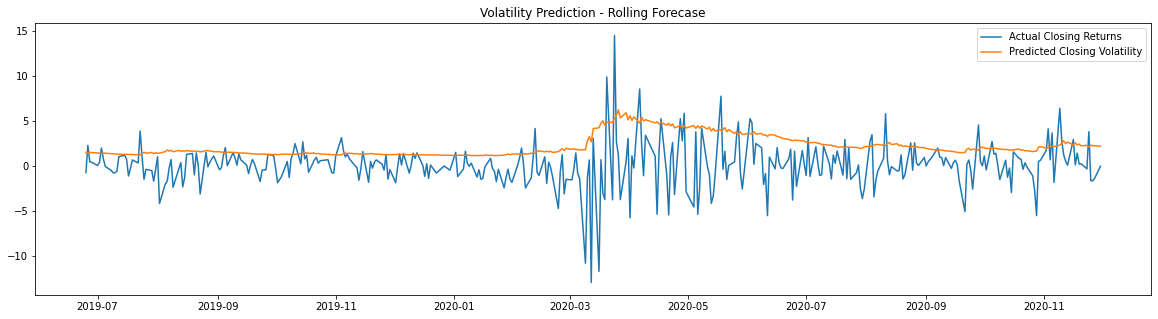

In [86]:
plt.figure(figsize=(20,5))
true, = plt.plot(bmw_returns[-365:])
b_preds, = plt.plot(bmw_rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecase')
plt.legend(['Actual Closing Returns','Predicted Closing Volatility'])

In [87]:
b_train = bmw_returns
bmwmodel = arch_model(b_train, p = 2, q =2)
bmwmodel_fit = bmwmodel.fit(disp = 'off')

In [ ]:
b_preds = bmwmodel_fit.forecast(horizon = 7)
bmw_future_dates = [bmw_returns.index[-1] + timedelta(days = i) for i in range(1,8)]
b_preds = pd.Series(np.sqrt(b_preds.variance.values[-1,:]), index = bmw_future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

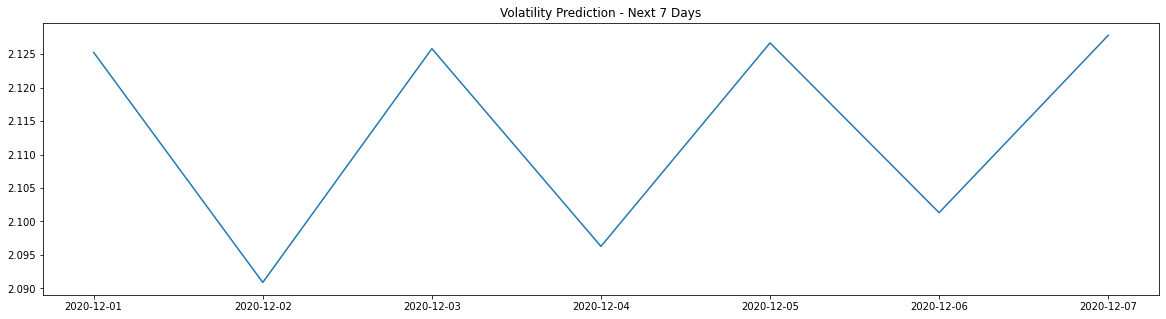

In [89]:
plt.figure(figsize=(20,5))
plt.plot(b_preds)
plt.title('Volatility Prediction - Next 7 Days')

Crude Oil

In [42]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [43]:
link = 'https://drive.google.com/file/d/1bDmksCT2qU5xelMH8IpulvcfM9r9lnPz/view?usp=sharing'

In [44]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('crudeoil.csv')
oildf = pd.read_csv('crudeoil.csv')

In [45]:
from google.colab import files
oildf.to_csv('crudeoil.csv') 
#files.download('crudeoil.csv')

In [46]:
print(oildf.isnull().sum())

Date            0
Open         1145
High         1145
Low          1145
Close        1145
Adj Close    1145
Volume       1145
dtype: int64


In [47]:
#dropping null values - no trading on weekends or holidays
oildf = oildf.dropna()

In [48]:
oildf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 0 to 6243
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5099 non-null   object 
 1   Open       5099 non-null   float64
 2   High       5099 non-null   float64
 3   Low        5099 non-null   float64
 4   Close      5099 non-null   float64
 5   Adj Close  5099 non-null   float64
 6   Volume     5099 non-null   float64
dtypes: float64(6), object(1)
memory usage: 318.7+ KB


In [49]:
oildf['Datetime'] = pd.to_datetime(oildf['Date'])
oildf = oildf.set_index('Datetime')

In [50]:
oildf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5099 entries, 2000-03-22 to 2020-07-21
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5099 non-null   object 
 1   Open       5099 non-null   float64
 2   High       5099 non-null   float64
 3   Low        5099 non-null   float64
 4   Close      5099 non-null   float64
 5   Adj Close  5099 non-null   float64
 6   Volume     5099 non-null   float64
dtypes: float64(6), object(1)
memory usage: 318.7+ KB


In [ ]:
#oildf['Date']= oildf['Date'].astype('datetime64[ns]')

In [51]:
oildf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2000-03-22,2000-03-22,27.65,28.250000,27.250000,27.459999,27.459999,92302.0
2000-03-23,2000-03-23,27.65,27.780001,27.160000,27.309999,27.309999,79373.0
2000-03-24,2000-03-24,27.85,28.150000,27.549999,27.980000,27.980000,55693.0
2000-03-27,2000-03-27,27.65,28.020000,27.410000,27.730000,27.730000,59199.0
2000-03-28,2000-03-28,27.60,27.870001,27.000000,27.080000,27.080000,39487.0


In [52]:
oil_returns = 100 * oildf.Close.pct_change().dropna()

Text(0.5, 1.0, 'Crude Oil Returns')

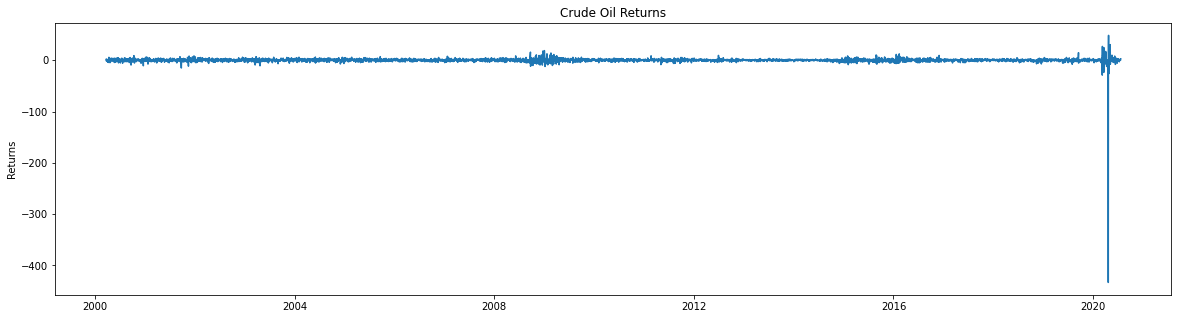

In [53]:
plt.figure(figsize = (20,5))
plt.plot(oil_returns)
plt.ylabel('Returns')
plt.title('Crude Oil Returns')
#percent change of tesla stock between one day in the next from 2010(June) to 2020(November)

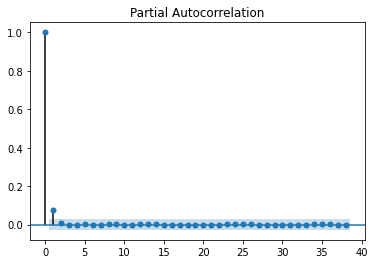

In [54]:
plot_pacf(oil_returns**2)
plt.show()

In [55]:
oilmodel = arch_model(oil_returns, p = 1, q = 1)

In [ ]:
oilmodel_fit = oilmodel.fit()

In [57]:
oilmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11457.0
Distribution:                  Normal   AIC:                           22922.0
Method:            Maximum Likelihood   BIC:                           22948.1
                                        No. Observations:                 5098
Date:                Fri, May 14 2021   Df Residuals:                     5097
Time:                        16:28:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0904  2.932e-02      3.083  2.046e-03 [3.294e-02,  0.148]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1034  9.783e-02      1.057      0.291 [-8.837e-02,  0.295]
alpha[1]       0.1411  3.058e-02      4.615  3.938e-06  [8.118e-02,  0.201]
beta[1]        0.8589  4.219e-02     20.357  3.985e-92    [  0.776,  0.942]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
oil_rolling_predictions = []
o_test_size = 365

for i in range(o_test_size):
  o_train = oil_returns[:-(o_test_size-i)]
  oilmodel = arch_model(o_train, p = 1, q = 1)
  oilmodel_fit = oilmodel.fit(disp = 'off')
  o_preds = oilmodel_fit.forecast(horizon = 1)
  oil_rolling_predictions.append(np.sqrt(o_preds.variance.values[-1,:][0]))

In [59]:
oil_rolling_predictions = pd.Series(oil_rolling_predictions, index = oil_returns.index[-365:])

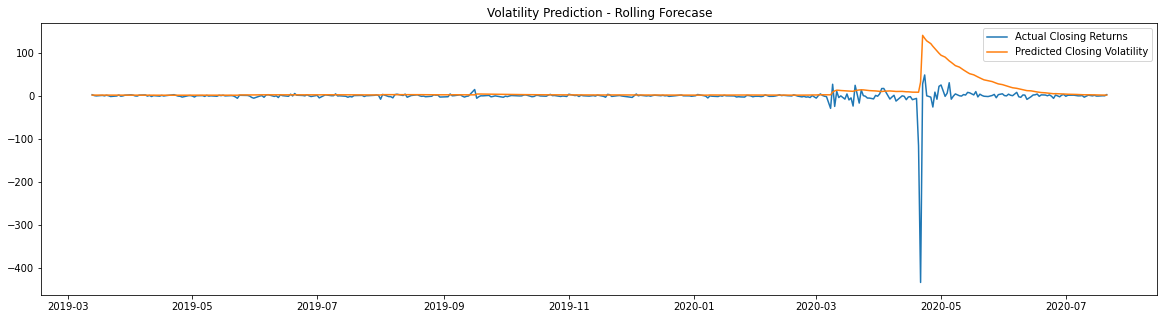

In [60]:
plt.figure(figsize=(20,5))
true, = plt.plot(oil_returns[-365:])
o_preds, = plt.plot(oil_rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecase')
plt.legend(['Actual Closing Returns','Predicted Closing Volatility'])

In [61]:
o_train = oil_returns
oilmodel = arch_model(o_train, p = 1, q =1) 
oilmodel_fit = oilmodel.fit(disp = 'off')

In [ ]:
o_preds = oilmodel_fit.forecast(horizon = 7)
oil_future_dates = [oil_returns.index[-1] + timedelta(days = i) for i in range(1,8)]
o_preds = pd.Series(np.sqrt(o_preds.variance.values[-1,:]), index = oil_future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

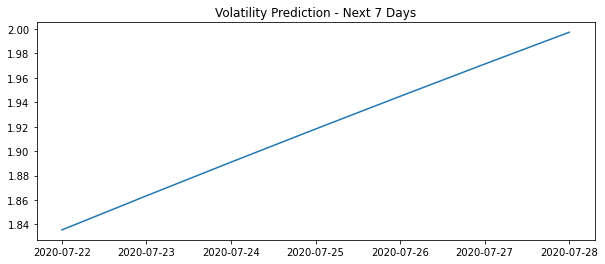

In [63]:
plt.figure(figsize=(10,4))
plt.plot(o_preds)
plt.title('Volatility Prediction - Next 7 Days')

JUstr trying it out with the rest of the dataset although it mostly works with stocks

**Carbon **

In [ ]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#carbon
link = 'https://drive.google.com/file/d/1vZGR58aOIt4b58EyFFzqf2SdH0XVFLw-/view?usp=sharing'

In [ ]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('carbonemissions.csv')
carbondf = pd.read_csv('carbonemissions.csv')

In [ ]:
from google.colab import files
carbondf.to_csv('carbonemissions.csv') 
#files.download('carbonemissions.csv')

In [ ]:
carbondf = carbondf[carbondf.country == 'United States']

In [ ]:
carbondf.drop(['iso_code','co2_growth_abs','consumption_co2','trade_co2','trade_co2_share','co2_per_capita','consumption_co2_per_capita','cumulative_co2','share_global_cumulative_co2','consumption_co2_per_gdp','co2_per_unit_energy','cement_co2','coal_co2','flaring_co2','gas_co2','oil_co2','cement_co2_per_capita','coal_co2_per_capita','flaring_co2_per_capita','gas_co2_per_capita','oil_co2_per_capita','total_ghg','ghg_per_capita','methane','methane_per_capita','nitrous_oxide','nitrous_oxide_per_capita','primary_energy_consumption','energy_per_capita','energy_per_gdp','population','gdp','co2_growth_prct'], axis=1, inplace=True)

In [ ]:
carbondf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 22625 to 22892
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           268 non-null    object 
 1   year              268 non-null    int64  
 2   co2               268 non-null    float64
 3   share_global_co2  268 non-null    float64
 4   co2_per_gdp       197 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 12.6+ KB


In [ ]:
carbondf['co2_per_gdp'] = carbondf['co2_per_gdp'].fillna(0)

In [ ]:
carbondf = carbondf[carbondf.year > 1799]
#only startng at 1800 since that is the starting values with no 0s exclu co2_gdp

In [ ]:
carbon_returns = 100 * carbondf.co2.pct_change().dropna()
carbon_returns1 = 100 * carbondf.co2_per_gdp.pct_change().dropna()
carbon_returns2 = 100 * carbondf.share_global_co2.pct_change().dropna()

Text(0.5, 1.0, 'CO2 Share Global Returns')

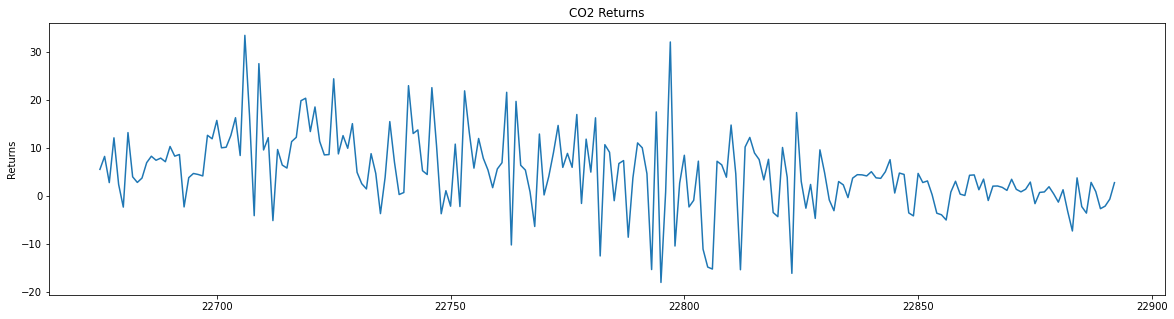

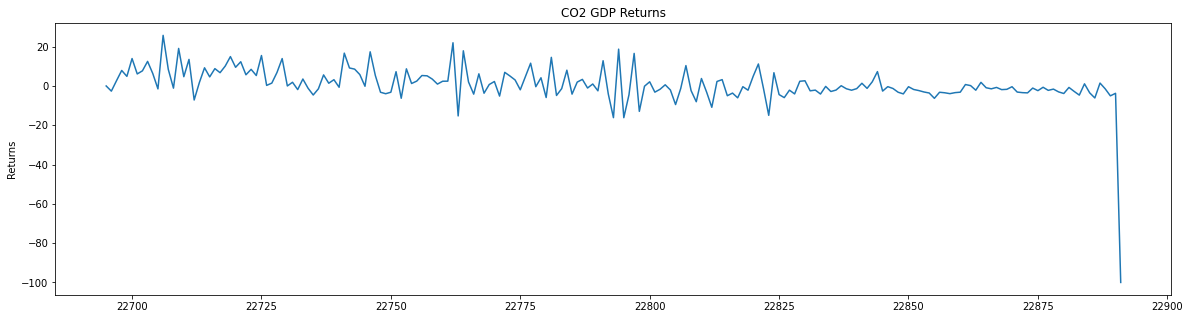

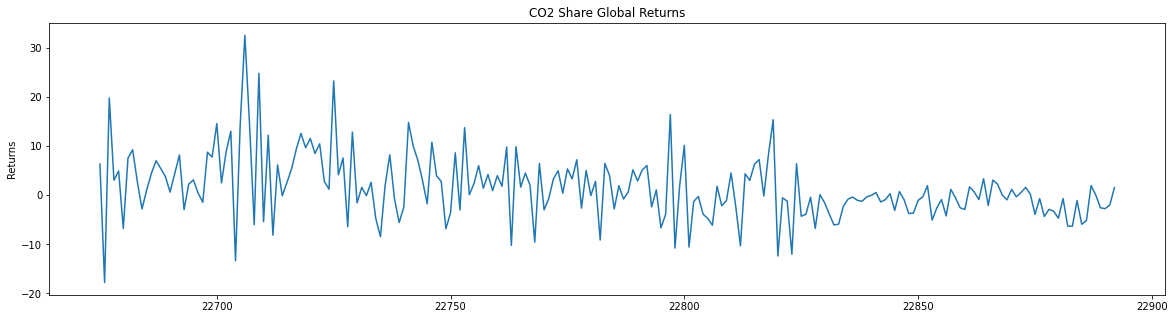

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(carbon_returns)
plt.ylabel('Returns')
plt.title('CO2 Returns')

plt.figure(figsize = (20,5))
plt.plot(carbon_returns1)
plt.ylabel('Returns')
plt.title('CO2 GDP Returns')

plt.figure(figsize = (20,5))
plt.plot(carbon_returns2)
plt.ylabel('Returns')
plt.title('CO2 Share Global Returns')

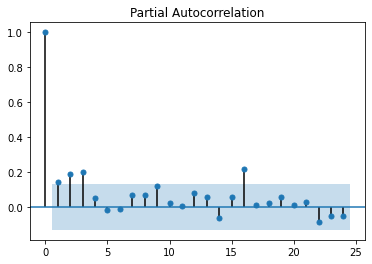

In [ ]:
plot_pacf(carbon_returns**2)
plt.show()

In [ ]:
co2model = arch_model(carbon_returns, p = 5, q = 5)
co2model_fit = co2model.fit()

In [ ]:
co2model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -743.256
Distribution:                  Normal   AIC:                           1510.51
Method:            Maximum Likelihood   BIC:                           1551.13
                                        No. Observations:                  218
Date:                Wed, May 05 2021   Df Residuals:                      217
Time:                        11:50:24   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2.5130      0.685      3.670  2.430e-04 [  1.171,  3.855]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.3915      2.764      0.865      0.387   [ -3.025,  7.808]
alpha[1]       0.1950  8.444e-02      2.309  2.092e-02 [2.951e-02,  0.361]
alpha[2]       0.2238      0.176      1.269      0.204   [ -0.122,  0.569]
alpha[3]   9.0304e-03      0.283  3.187e-02      0.975   [ -0.546,  0.564]
alpha[4]       0.1352      0.199      0.679      0.497   [ -0.255,  0.525]
alpha[5]       0.0525      0.170      0.308      0.758   [ -0.281,  0.386]
beta[1]    1.4242e-12      0.725  1.963e-12      1.000   [ -1.422,  1.422]
beta[2]        0.0973      0.441      0.221      0.825   [ -0.767,  0.962]
beta[3]    7.4207e-12      0.408  1.820e-11      1.000   [ -0.799,  0.799]
beta[4]        0.0000      0.491      0.000      1.000   [ -0.963,  0.963]
beta[5]        0.2873      0.212      1.354      0.176   [ -0.128,  0.703]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
co2model = arch_model(carbon_returns, p = 1, q = 0)
co2model_fit = co2model.fit()

In [ ]:
co2model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -761.869
Distribution:                  Normal   AIC:                           1529.74
Method:            Maximum Likelihood   BIC:                           1539.89
                                        No. Observations:                  218
Date:                Wed, May 05 2021   Df Residuals:                      217
Time:                        11:52:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.8993      0.593      8.257  1.491e-16 [  3.736,  6.062]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         54.9373      9.677      5.677  1.370e-08    [ 35.971, 73.904]
alpha[1]       0.1599  8.895e-02      1.798  7.225e-02 [-1.445e-02,  0.334]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
co2_rolling_predictions = []
co2_test_size = 365 #365 days

In [ ]:
for i in range(co2_test_size):
  co2_train = carbon_returns[:-(co2_test_size-i)]
  co2model = arch_model(co2_train, p = 1, q = 0)
  co2model_fit = co2model.fit(disp = 'off')
  co2_preds = co2model_fit.forecast(horizon=1)
  co2_rolling_predictions.append(np.sqrt(co2_preds.variance.values[-1,:][0]))

ValueError: ignored

In [ ]:
#carbon_returns1 ignored even filtering it to 1800s onwards 

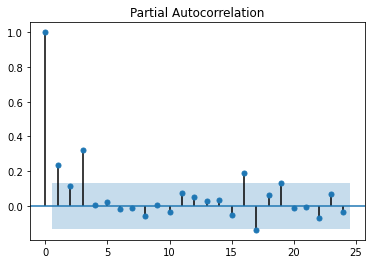

In [ ]:
plot_pacf(carbon_returns2**2)
plt.show()

In [ ]:
sharemodel = arch_model(carbon_returns2, p = 4, q = 4)
sharemodel_fit = sharemodel.fit()

In [ ]:
sharemodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:       share_global_co2   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -689.457
Distribution:                  Normal   AIC:                           1398.91
Method:            Maximum Likelihood   BIC:                           1432.76
                                        No. Observations:                  218
Date:                Wed, May 05 2021   Df Residuals:                      217
Time:                        12:01:01   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3413      0.414     -0.824      0.410 [ -1.153,  0.471]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.4961      2.156      0.694      0.488   [ -2.729,  5.721]
alpha[1]       0.2179  8.818e-02      2.471  1.349e-02 [4.504e-02,  0.391]
alpha[2]       0.2298      0.279      0.824      0.410   [ -0.317,  0.776]
alpha[3]       0.0600      0.196      0.306      0.759   [ -0.324,  0.444]
alpha[4]       0.0839      0.187      0.448      0.654   [ -0.283,  0.451]
beta[1]        0.1879      1.206      0.156      0.876   [ -2.176,  2.552]
beta[2]        0.0000      0.877      0.000      1.000   [ -1.718,  1.718]
beta[3]        0.0000      1.007      0.000      1.000   [ -1.974,  1.974]
beta[4]        0.2206      0.798      0.276      0.782   [ -1.344,  1.785]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
sharemodel = arch_model(carbon_returns2, p = 1, q = 0)
sharemodel_fit = sharemodel.fit()

In [ ]:
sharemodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:       share_global_co2   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -709.084
Distribution:                  Normal   AIC:                           1424.17
Method:            Maximum Likelihood   BIC:                           1434.32
                                        No. Observations:                  218
Date:                Wed, May 05 2021   Df Residuals:                      217
Time:                        12:01:30   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0692      0.459      2.327  1.995e-02 [  0.169,  1.970]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         25.2111      5.968      4.224  2.398e-05 [ 13.514, 36.909]
alpha[1]       0.4990      0.200      2.489  1.279e-02 [  0.106,  0.892]
========================================================================

Covariance estimator: robust
"""

In [ ]:
share_rolling_predictions = []
share_test_size = 365 #365 days

In [ ]:
for i in range(share_test_size):
  share_train = carbon_returns2[:-(share_test_size-i)]
  sharemodel = arch_model(share_train, p = 1, q = 0)
  sharemodel_fit = sharemodel.fit(disp = 'off')
  share_preds = sharemodel_fit.forecast(horizon=1)
  share_rolling_predictions.append(np.sqrt(share_predd.variance.values[-1,:][0]))

ValueError: ignored

**Fossil Fuel**

In [ ]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/17UyI499mUj2nc6-Qp24NoS_wo-YSQHdw/view?usp=sharing'

In [ ]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fossilConsumption.csv')
fossildf = pd.read_csv('fossilConsumption.csv')

In [ ]:
from google.colab import files
fossildf.to_csv('fossilConsumption.csv') 
#files.download('fossilConsumption.csv')

In [ ]:
#renaming columns
fossildf.rename(columns = {'Coal Consumption - EJ':'CoalConsumption', 'Gas Consumption - EJ':'GasConsumption', 
                              'Oil Consumption - EJ':'OilConsumption','Year':'year'}, inplace = True) 

In [ ]:
#dropping code since it is not needed
fossildf.drop('Code', axis='columns', inplace=True)

In [ ]:
#only using USA, dropping other countries
fossildf = fossildf[fossildf.Entity == 'United States']

GARCH

In [ ]:
fossil_returns = 100 * fossildf.OilConsumption.pct_change().dropna()
fossil_returns1 = 100 * fossildf.CoalConsumption.pct_change().dropna()
fossil_returns2 = 100 * fossildf.GasConsumption.pct_change().dropna()

Text(0.5, 1.0, 'Gas Consumption Returns')

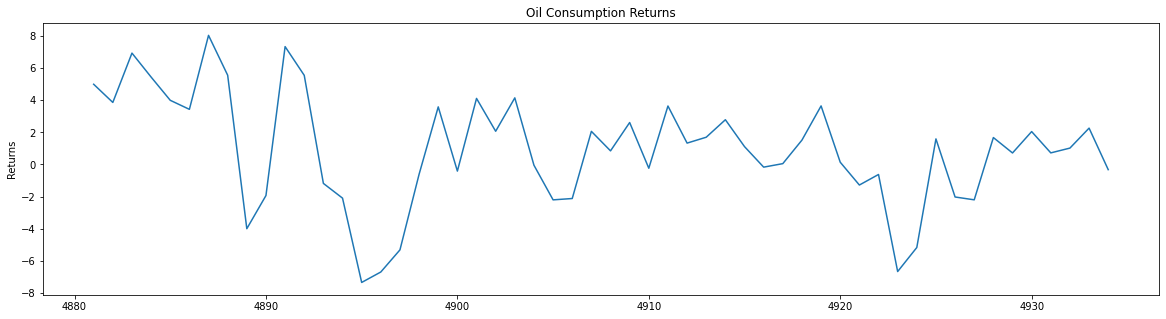

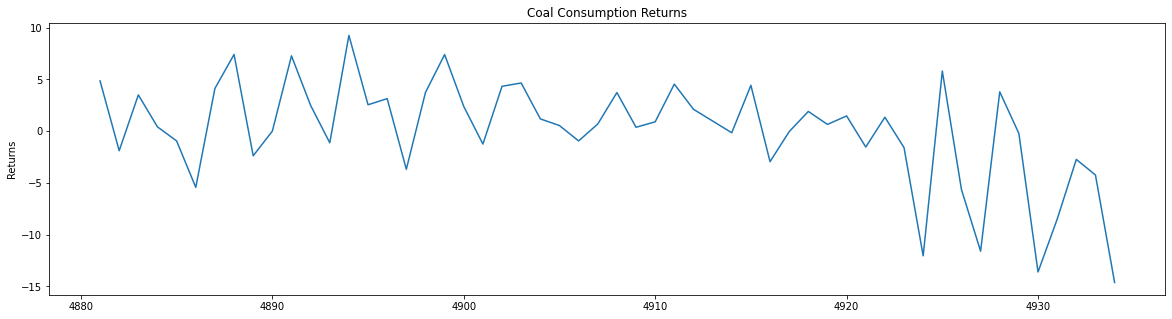

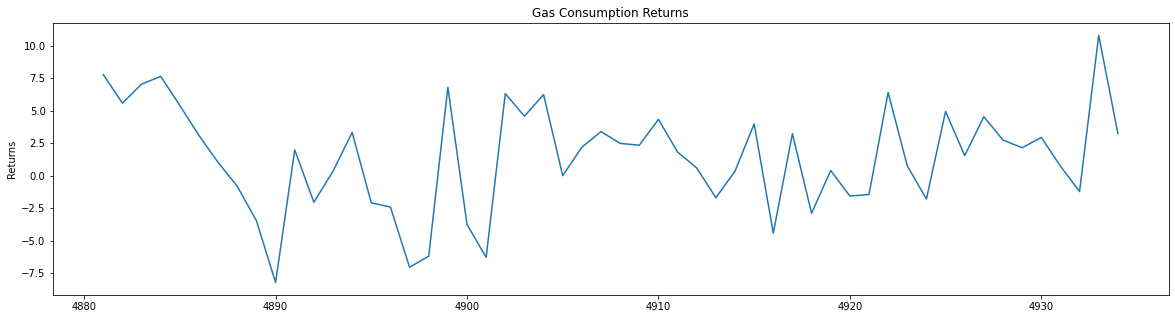

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(fossil_returns)
plt.ylabel('Returns')
plt.title('Oil Consumption Returns')

plt.figure(figsize = (20,5))
plt.plot(fossil_returns1)
plt.ylabel('Returns')
plt.title('Coal Consumption Returns')

plt.figure(figsize = (20,5))
plt.plot(fossil_returns2)
plt.ylabel('Returns')
plt.title('Gas Consumption Returns')

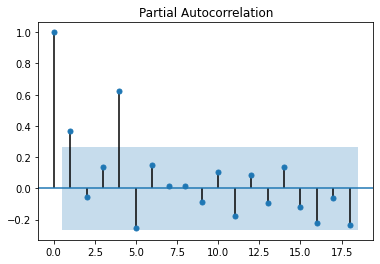

In [ ]:
plot_pacf(fossil_returns**2)
plt.show()

In [ ]:
fossiloil_model = arch_model(fossil_returns, p = 4, q = 5)
fossiloil_model_fit = fossiloil_model.fit()

In [ ]:
fossiloil_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         OilConsumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -134.617
Distribution:                  Normal   AIC:                           291.233
Method:            Maximum Likelihood   BIC:                           313.112
                                        No. Observations:                   54
Date:                Wed, May 05 2021   Df Residuals:                       53
Time:                        11:31:23   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6414      1.137      0.564      0.573 [ -1.588,  2.871]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.9733      1.213      1.626      0.104 [ -0.405,  4.351]
alpha[1]       0.1954      0.499      0.392      0.695 [ -0.783,  1.173]
alpha[2]       0.0347      0.428  8.115e-02      0.935 [ -0.803,  0.873]
alpha[3]   5.5997e-14      0.231  2.423e-13      1.000 [ -0.453,  0.453]
alpha[4]       0.5469      1.392      0.393      0.694 [ -2.181,  3.275]
beta[1]        0.0000      2.383      0.000      1.000 [ -4.670,  4.670]
beta[2]        0.0000      0.572      0.000      1.000 [ -1.120,  1.120]
beta[3]        0.0000      1.308      0.000      1.000 [ -2.563,  2.563]
beta[4]    5.5479e-15      1.350  4.108e-15      1.000 [ -2.647,  2.647]
beta[5]        0.0000      0.370      0.000      1.000 [ -0.725,  0.725]
========================================================================

Covariance estimator: robust
"""

In [ ]:
fossiloil_model = arch_model(fossil_returns, p = 3, q = 4)
fossiloil_fit = fossiloil_model.fit()

In [ ]:
fossiloil_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         OilConsumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -136.623
Distribution:                  Normal   AIC:                           291.246
Method:            Maximum Likelihood   BIC:                           309.147
                                        No. Observations:                   54
Date:                Wed, May 05 2021   Df Residuals:                       53
Time:                        11:32:38   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.3285      0.228      5.816  6.020e-09 [  0.881,  1.776]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.1267      0.492      2.289  2.209e-02   [  0.162,  2.092]
alpha[1]       0.3606      0.154      2.345  1.903e-02 [5.920e-02,  0.662]
alpha[2]       0.5413      0.214      2.524  1.162e-02   [  0.121,  0.962]
alpha[3]       0.0000      0.256      0.000      1.000   [ -0.502,  0.502]
beta[1]    6.4598e-15      0.279  2.313e-14      1.000   [ -0.547,  0.547]
beta[2]        0.0982      0.201      0.487      0.626   [ -0.297,  0.493]
beta[3]    1.3178e-13      0.142  9.285e-13      1.000   [ -0.278,  0.278]
beta[4]    1.4998e-13      0.190  7.887e-13      1.000   [ -0.373,  0.373]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
oilf_rolling_predictions = []
of_test_size = 365 #365 days

In [ ]:
for i in range(of_test_size):
  of_train = fossil_returns[:-(of_test_size-i)]
  fossiloil_model = arch_model(of_train, p = 3, q = 4)
  fossiloil_model_fit = fossiloil_model.fit(disp = 'off')
  of_preds = fossiloil_model_fit.forecast(horizon=1)
  oilf_rolling_predictions.append(np.sqrt(of_preds.variance.values[-1,:][0]))

ValueError: ignored

In [ ]:
oilf_rolling_predictions = pd.Series(oilf_rolling_predictions, index = fossil_returns.index[-365:])

In [ ]:
plt.figure(figsize=(20,5))
true, = plt.plot(fossil_returns[-365:])
ofpred, = plt.plot(oilf_rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecase')
plt.legend(['Actual CO2 Returns','Predicted CO2 Volatility'])

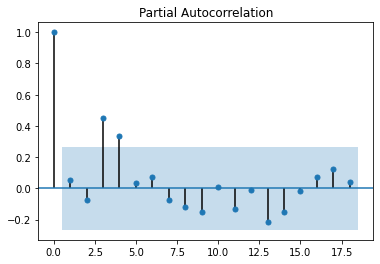

In [ ]:
plot_pacf(fossil_returns1**2)
plt.show()

In [ ]:
fossilcoal_model = arch_model(fossil_returns1, p = 4, q = 5)
fossilcoal_model_fit = fossilcoal_model.fit()

In [ ]:
fossilcoal_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:        CoalConsumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -153.948
Distribution:                  Normal   AIC:                           329.896
Method:            Maximum Likelihood   BIC:                           351.775
                                        No. Observations:                   54
Date:                Wed, May 05 2021   Df Residuals:                       53
Time:                        11:40:03   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.3298      0.576      2.308  2.102e-02 [  0.200,  2.459]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6293      4.417      0.822      0.411 [ -5.028, 12.286]
alpha[1]       0.0910      0.120      0.760      0.447 [ -0.144,  0.326]
alpha[2]       0.0298  6.979e-02      0.427      0.669 [ -0.107,  0.167]
alpha[3]       0.6489      0.219      2.967  3.006e-03 [  0.220,  1.078]
alpha[4]       0.0000      0.584      0.000      1.000 [ -1.145,  1.145]
beta[1]        0.0000      0.578      0.000      1.000 [ -1.132,  1.132]
beta[2]        0.0000      0.135      0.000      1.000 [ -0.264,  0.264]
beta[3]        0.0000      0.236      0.000      1.000 [ -0.462,  0.462]
beta[4]        0.0000      0.262      0.000      1.000 [ -0.514,  0.514]
beta[5]        0.2302      0.218      1.056      0.291 [ -0.197,  0.658]
========================================================================

Covariance estimator: robust
"""

In [ ]:
fossilcoal_model = arch_model(fossil_returns1, p = 3, q = 0)
fossilcoal_model_fit = fossilcoal_model.fit()

In [ ]:
fossilcoal_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:        CoalConsumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -154.606
Distribution:                  Normal   AIC:                           319.213
Method:            Maximum Likelihood   BIC:                           329.158
                                        No. Observations:                   54
Date:                Wed, May 05 2021   Df Residuals:                       53
Time:                        11:41:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.2622      0.460      2.744  6.074e-03 [  0.361,  2.164]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          6.3757      3.160      2.017  4.366e-02    [  0.181, 12.570]
alpha[1]       0.1199  8.172e-02      1.467      0.142 [-4.025e-02,  0.280]
alpha[2]       0.0291  6.018e-02      0.484      0.628 [-8.880e-02,  0.147]
alpha[3]       0.8066      0.414      1.949  5.127e-02 [-4.448e-03,  1.618]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
fossilcoal_rolling_predictions = []
coal_test_size = 365 #365 days

In [ ]:
for i in range(coal_test_size):
  coal_train = fossil_returns1[:-(coal_test_size-i)]
  fossilcoal_model = arch_model(coal_train, p = 3, q = 0)
  fossilcoal_model_fit = fossilcoal_model.fit(disp = 'off')
  coal_preds = fossilcoal_model_fit.forecast(horizon=1)

ValueError: ignored

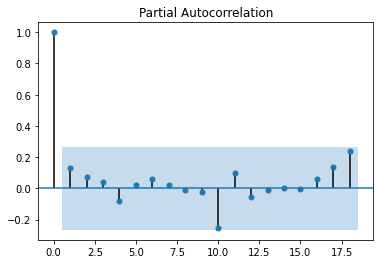

In [ ]:
plot_pacf(fossil_returns2**2)
plt.show()

In [ ]:
gasmodel = arch_model(fossil_returns2, p = 4, q = 4)
gasmodel_fit = gasmodel.fit()

In [ ]:
gasmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         GasConsumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -149.158
Distribution:                  Normal   AIC:                           318.316
Method:            Maximum Likelihood   BIC:                           338.206
                                        No. Observations:                   54
Date:                Wed, May 05 2021   Df Residuals:                       53
Time:                        12:04:08   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.8685      0.468      3.992  6.549e-05 [  0.951,  2.786]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          5.0568      7.515      0.673      0.501    [ -9.673, 19.787]
alpha[1]       0.8140      0.438      1.859  6.305e-02 [-4.430e-02,  1.672]
alpha[2]       0.0873      0.895  9.754e-02      0.922    [ -1.667,  1.842]
alpha[3]   1.2894e-14      0.427  3.018e-14      1.000    [ -0.837,  0.837]
alpha[4]   2.7960e-13      1.045  2.676e-13      1.000    [ -2.048,  2.048]
beta[1]    1.0224e-14      1.278  8.002e-15      1.000    [ -2.504,  2.504]
beta[2]    1.7099e-13      0.530  3.225e-13      1.000    [ -1.039,  1.039]
beta[3]    3.7710e-13      0.239  1.580e-12      1.000    [ -0.468,  0.468]
beta[4]    1.5502e-03  5.943e-02  2.609e-02      0.979    [ -0.115,  0.118]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
gasmodel = arch_model(fossil_returns2, p = 1, q = 0)
gasmodel_fit = gasmodel.fit()

In [ ]:
gasmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:         GasConsumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -149.457
Distribution:                  Normal   AIC:                           304.913
Method:            Maximum Likelihood   BIC:                           310.880
                                        No. Observations:                   54
Date:                Wed, May 05 2021   Df Residuals:                       53
Time:                        12:04:36   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.7088      0.471      3.630  2.837e-04 [  0.786,  2.632]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          6.8220      2.149      3.174  1.504e-03   [  2.609, 11.035]
alpha[1]       0.7349      0.338      2.174  2.969e-02 [7.242e-02,  1.397]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
gas_rolling_predictions = []
gas_test_size = 365 #365 days

for i in range(gas_test_size):
  gas_train = fossil_returns2[:-(gas_test_size-i)]
  gasmodel = arch_model(gas_train, p = 1, q = 0)
  gasmodel_fit = gasmodel.fit(disp = 'off')
  gas_preds = gasmodel_fit.forecast(horizon=1)

ValueError: ignored